# Exercise 2: Beamforming 

# B-mode imaging and beamforming

- B-mode imaging is a modality invloving multiple US transducer channels
- **B-mode** stands for **brightness mode**. 
- Ultrasound **B-mode images are reflectivity maps** where bright pixels correspond to the highly reflective areas.
  Similarly, the pixels with low intensity correpond to the areas with low-reflectivity.

An example ultrasound image of the Common Carotid Artery is shown below:

<img src='images/ex6_carotid_us_imag_0.drawio.png'>

- The top part of the image corresponds to the superficial tissues (close to the skin surface) while the bottom part of the image shows deep tissue.
- Z axis is prependicular to the skin surface and x axis is parallel  to the skin surface.

#### How to reconstruct an image from raw US data?

- **To reconstruct the ultrasound image** from raw data, we employ an algorithm called **beamformer**.
- The process of image reconstruction is, respectively, called **beamforming**.
- The most common beamforming algorithm is **Delay-and-Sum (DAS)** algorithm. The block diagram of the algorithm is shown below:

<img src='images/ex6_beamforming.drawio.png'>

- Most of the building blocks we already know (marked with green).
- The orange blocks are new for us. The most important of them is **Delay and Sum (DAS) block**.
- Before the DAS block, the data from multiple channels are processed separately.
- DAS is a key step, when the data from transducer channels are combined together to build an Ultrasound image.

The diagram below conceptually visualizes the calculations of DAS block for each pixel of the output image.
- Each pixel (Source) has fixed coordinates $(x_0, z_0)$. Its position with respect to the transducer channels is known.
- **The distances** from the source to each channel **are different**.Therefore, a reflected pressure wave takes different amount of time to travel back to the transducer channels. 
- That means, **the same backscattered signal** captured by **different transducer channels** appears **delayed in time**.
- **DAS** algorithm **applies compensating delays** (based on relative positions of the source and channels) and **aligns the received signals in time**.

- Then, **DAS sums up the aligned signals** from different channels. Constructive interference increases the amplitude of the reflected signal. Instead, if we would not have a scatterer at the position of the source, we would sum up some noise with undefined phase (destructive interference).

- The normalization step is optional

- **The process** described above **repeats for every pixel** of the image. That is how we reconstruct an image with DAS block

<img src='images/ex6_beamforming_das.drawio.png'>

- In the next part of the exercise, you will explore the unknown (orange) blocks by experimenting with the Python implemetation of DAS algorithm provided by [PyBF library](https://github.com/Sergio5714/pybf).

### Beamforming example

In [ ]:
# beamforming class
# Import PyBF library
import numpy as np
from scipy import signal as ss
import sys, os
'''
import sys, os
look here if below import doesn't work: https://stackoverflow.com/questions/7505988/importing-from-a-relative-path-in-python
'''
# sys.path.append('../jupyter')
sys.path.append('.')
from pybf.scripts.beamformer_cartesian_realtime import BFCartesianRealTime
from pybf.pybf.transducer import Transducer
from pybf.pybf.visualization import plot_image
from pybf.pybf.image_settings import ImageSettings
# from beamformer import Transducer, ImageSettings, BFCartesianRealTime, plot_image

### Specify Trancducer settings and create transducer object ###

# Transducer settings dictionary
# transducer_config = {
#     'F_CENTRAL': 5.13 * 10 ** 6,
#     'X_ELEM': 128,
#     'X_PITCH': 0.0003,
#     'X_WIDTH': 0,
#     'Y_ELEM': 1,
#     'Y_PITCH': 0,
#     'Y_WIDTH': 0
# }

class Delay_and_Sum_Beamformer:
    def __init__(self, path_to_data, transducer_config=None):
        self.path_to_data = path_to_data
        self.transducer_config = transducer_config or {
            'F_CENTRAL': 5.13 * 10 ** 6,
            'X_ELEM': 128,
            'X_PITCH': 0.0003,
            'X_WIDTH': 0,
            'Y_ELEM': 1,
            'Y_PITCH': 0,
            'Y_WIDTH': 0
        }

    def run_beamformer(self):
        # Load RF data from path_to_data
        rf_data = np.genfromtxt(self.path_to_data, delimiter=',')

        # Transducer settings
        F_CENTRAL = self.transducer_config['F_CENTRAL']
        X_ELEM = self.transducer_config['X_ELEM']
        X_PITCH = self.transducer_config['X_PITCH']
        X_WIDTH = self.transducer_config['X_WIDTH']
        Y_ELEM = self.transducer_config['Y_ELEM']
        Y_PITCH = self.transducer_config['Y_PITCH']
        Y_WIDTH = self.transducer_config['Y_WIDTH']

        # Set all transducer elements (channels) to be active by default
        active_elements = np.arange(X_ELEM)

        # Create transducer object
        trans = Transducer(num_of_x_elements=X_ELEM,
                           num_of_y_elements=Y_ELEM,
                           x_pitch=X_PITCH,
                           y_pitch=Y_PITCH,
                           x_width=X_WIDTH,
                           y_width=Y_WIDTH,
                           f_central_hz=F_CENTRAL,
                           bandwidth_hz=F_CENTRAL,
                           active_elements=active_elements)

        ### Specify Image settings and create corresponding object ###
        img_res = [400, 600]
        image_x_range = [-0.018, 0.018]
        image_z_range = [0.000, 0.1]

        LATERAL_PIXEL_DENSITY_DEFAULT = 5

        img_config = ImageSettings(image_x_range[0],
                                   image_x_range[1],
                                   image_z_range[0],
                                   image_z_range[1],
                                   LATERAL_PIXEL_DENSITY_DEFAULT,
                                   trans)

        ### Specify preprocessing parameters for RF data ###
        decimation_factor = 1
        interpolation_factor = 10

        ### Specify TX strategy and Apodization parameters ###
        start_time = 0
        correction_time_shift = 0

        alpha_fov_apod = 40

        # 1 Plane waves with inclination angle 0
        tx_strategy = ['PW_1_0', [0]]

        ### Specify Sampling Frequency ###
        SAMPLING_FREQ = 20.832 * (10 ** 6)

        bp_filters_params = [1 * 10 **6, 8 * 10 **6, 0.5 * 10 **6]

        # Create an instance of beamformer
        bf = BFCartesianRealTime(SAMPLING_FREQ,
                                 tx_strategy,
                                 trans,
                                 decimation_factor,
                                 interpolation_factor,
                                 img_res,
                                 img_config,
                                 start_time=start_time,
                                 correction_time_shift=correction_time_shift,
                                 alpha_fov_apod=alpha_fov_apod,
                                 bp_filter_params=bp_filters_params)

        # Run beamformer
        img_data = bf.beamform(rf_data[active_elements])

        # Prepare parameters for plot_image
        params = {
            'img_data': img_data,
            'scatters_coords_xz': None,
            'elements_coords_xz': trans.elements_coords,
            'framework': 'matplotlib',
            'title': 'Sample Image',
            'image_x_range': image_x_range,
            'image_z_range': image_z_range,
            'db_range': 80,
            'colorscale': 'Greys',
            'save_fig': False,
            'show': True,
            'path_to_save': '.'
        }

        return params


In [2]:
# cannot use relative imports in jupyter notebooks
import sys, os
import numpy as np
# sys.path.append(os.path.join(os.path.dirname(__file__), '/..', '/python'))
sys.path.append('pybf')
sys.path.append('../python')

from pybf.pybf.visualization import plot_image
from beamformer import Delay_and_Sum_Beamformer

DAS = Delay_and_Sum_Beamformer(path_to_data = 'raw_data_beamforming.csv')

params = DAS.run_beamformer()

Transducer: number of active elements =  128
The highest resolution for the system is:  (600, 333)
Delays precalculation...
TX strategy: plane waves
Number of plane waves:  1
Maximum angle:  0.0 °
Apodization precalculation...
Beamforming...
 
Time of execution: 0.96836256980896 seconds


c:\Vault\Documents\_RealLifeFolder\_School\_ETH\Bachelor of Science\7. Semester\P&S\Wearable Ultrasound\Beamforming\juypter\pybf\pybf\visualization.py:54: RuntimeWarning:

divide by zero encountered in log10



BF Final dB range (-80.0,0.0)


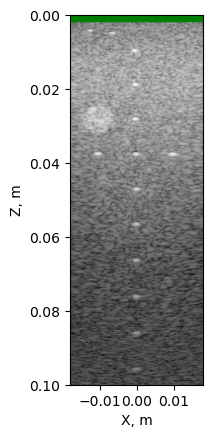

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='X, m', ylabel='Z, m'>)

In [3]:
# remove img_data from params, because it already passed to plot_image (through np.abs)
filtered_params = {k: v for k, v in params.items() if k != 'img_data'}
plot_image(np.abs(params['img_data']), **filtered_params)

# Plot image and save it.
# plot_image(np.abs(params.img_data), 
#            scatters_coords_xz=None,
#            elements_coords_xz=trans.elements_coords,
#            framework='matplotlib',
#            title='Sample Image',
#            image_x_range=image_x_range,
#            image_z_range=image_z_range,
#            db_range=50,
#            colorscale='Greys',
#            save_fig=False, 
#            show=True,
#            path_to_save='.')

## $\color{green}{\textbf{Task 3: Explore the PyBF example code}}$

### $\color{green}{\textbf{Task 3.1: Explore the image settings object}}$
Play with the input parameters of the `ImageSettings` constructor to adapt the resolution and position of the image.

**Hint**: Change the lists `image_x_range` and `image_z_range` to change the location, width and hight of the reconstructed image.

Answer the following question:
- Given the speed of sound $c = 1540\;m/s$ and the data we have, calculate the maximum imaging depth. Do not forget to account for the decimation factor, which reduced the amount of samples we have. A decimation factor of 1 means we discard every second sample.

- Change the list `image_z_range` to match the maximum imaging depth

- Then, reconstruct the image and calculate the number of scatters you can spot in the image.
  
- Answer the quiz

**Note**: There is a white spot in the image that is not a scatter but an inclusion. Please, do not count it.

In [ ]:
from jupyterquiz import display_quiz
load_quiz(2)

### $\color{green}{\textbf{Task 3.2: Play with the number of input channels}}$
You can reconstruct the image from a data with different number of channels.
This parameter is controlled by the parameter `active_elements` of the `Transducer` object. This array contains indices of the transducer channels (ranging from 0 to 127) which we would like to activate. It means the information only from these channels will be used during the beamforming.  

- Modify this parameter to imitate the transducer with different number of channels. We have prepared a few `active_elements` configurations for you. Just uncomment them one by one and run again the beamforming.
- Compare the quality of the images reconstructed with different number of channels. Discuss your observations with the TAs.

### $\color{green}{\textbf{Task 3.3: Visualize DAS output}}$
Visualize the output of DAS beamformer after computing the absolute value of the complex signal.

- What can you say about the image? Can we see fine structures in the US image?
- Discuss your observations with the TAs.

**Note**: Use the function `plt.imshow` with the parameter `cmap="gray"` to visualize the data.

In [ ]:
from matplotlib import pyplot as plt

### Put your answer here START

# Plot the signal and its envelope
plt.figure()

plt.imshow(np.abs(img_data), cmap="gray")
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.title('Original signal')

### Put your answer here END

### $\color{green}{\textbf{Task 3.4: Logarithmic compression}}$
The output of DAS tupically undergo logarithmic compression to visualize both structures with low and high reflectivity.

- Play with the parameter `db_range` of the `plot_image` function. This parameter preserves only those signals that are no more than X decibels (dBs) lower in intensity compared to the maximum value of the image.
Higher the decibel range, more fine (low-intensity) structures are visible in the image.